In [20]:

import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

PATH = '../../datasets/classification/dados_inadimplencia.csv'
df_data = pd.read_csv(PATH)
df_data.head()
# df_data.info()
#round(df_data.inadimplente.value_counts(normalize=True) * 100, 2)

,receita_cliente,anuidade_emprestimo,anos_casa_propria,telefone_trab,avaliacao_cidade,score_1,score_2,score_3,score_social,troca_telefone,inadimplente
0,16855.246324,2997.000000,12.157324,0,2.0,0.501213,0.003109,0.513171,0.117428,243.0,1
1,13500.000000,2776.050000,12.157324,0,2.0,0.501213,0.269730,0.513171,0.097900,617.0,0
2,11250.000000,2722.188351,12.157324,0,3.0,0.701396,0.518625,0.700184,0.118600,9.0,0
3,27000.000000,6750.000000,3.000000,0,2.0,0.501213,0.649571,0.513171,0.047400,300.0,0
4,22500.000000,3097.800000,12.157324,0,2.0,0.440744,0.509677,0.513171,0.014400,2913.0,1


### Conclusões

- Há 14578 linhas e 11 colunas no conjunto de dados
- Há `0 linhas duplicadas` no conjunto de dados
- Há `0 linhas com valores faltantes` nas colunas do conjunto de dados.

Logo, não há necessidade de tratamento de dados faltantes ou duplicados.

# Otimização de Hiperparâmetros 

In [21]:
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV


SEED=42
np.random.seed(SEED)
sns.set_style('whitegrid')
sns.set_palette('Set2')


df_X = df_data.drop(columns=['inadimplente'])
df_y = df_data['inadimplente']

x_train, x_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, stratify=df_y, random_state=42)

## Baseline Dummy
dummy_model = DummyClassifier()
dummy_model.fit(x_train, y_train)
acuracia_baseline = round(dummy_model.score(x_test, y_test) * 100, 2)
print(f'Acuracia Baseline Dummy: {acuracia_baseline}%')

## Baseline Decision Tree
dec_tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dec_tree_model.fit(x_train, y_train)
y_pred = dec_tree_model.predict(x_test)
acuracia_tree = round(accuracy_score(y_test, y_pred) * 100, 2)
recall_tree = round(recall_score(y_test, y_pred) * 100, 2)

# Baseline Logistic Regression
logistic_pipeline = make_pipeline(StandardScaler(), LogisticRegression())
logistic_pipeline.fit(x_train, y_train)
log_reg_prediction = logistic_pipeline.predict(x_test)
acuracia_lr = round(accuracy_score(y_test, log_reg_prediction) * 100, 2)
recall_lr = round(recall_score(y_test, log_reg_prediction) * 100, 2)


print(f'Acuracia Baseline Decision Tree: {acuracia_tree}%')
print(f'Acuracia Baseline Logistic Regression: {acuracia_lr}%')
print(f'Recall Baseline Decision Tree: {recall_tree}%')
print(f'Recall Baseline Logistic Regression: {recall_lr}%')

Acuracia Baseline Dummy: 67.65%
Acuracia Baseline Decision Tree: 69.48%
Acuracia Baseline Logistic Regression: 69.84%
Recall Baseline Decision Tree: 18.37%
Recall Baseline Logistic Regression: 25.09%


## 1 - Método GridSearch

### 1.1 - GridSearch com `DecisionTreeClassifier`

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[]

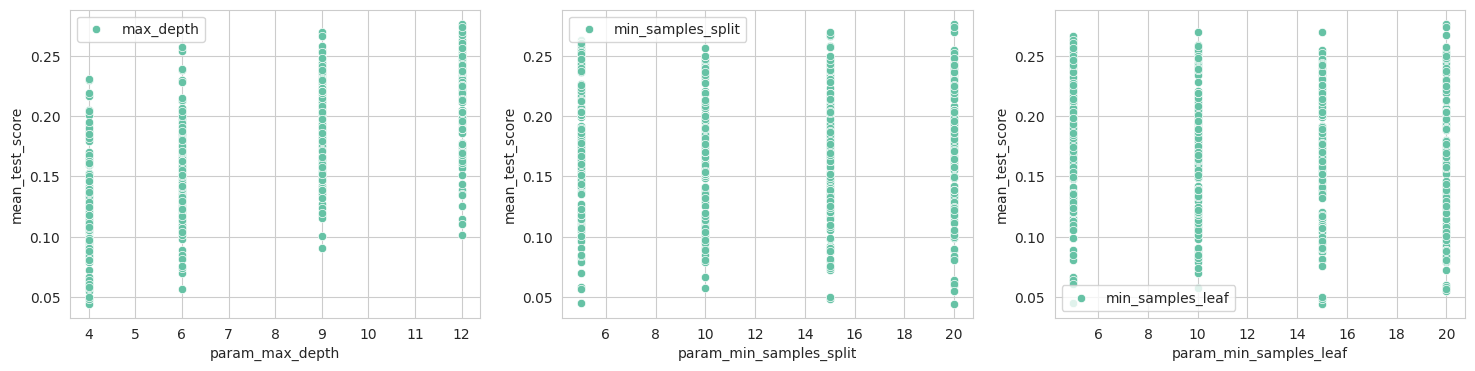

In [22]:
parms_grid_dec_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.linspace(4, 12, 4, dtype=int),
    'min_samples_split': np.linspace(5, 20, 4, dtype=int),
    'min_samples_leaf': np.linspace(5, 20, 4, dtype=int),
    'max_features': ['sqrt', 'log2'],
    'splitter': ['best', 'random'],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dec_tree_grid_search = GridSearchCV(
                                        estimator=DecisionTreeClassifier(), 
                                        param_grid=parms_grid_dec_tree, 
                                        cv=cv,
                                        scoring='recall',
                                        verbose=1,
                                        n_jobs=-1
)

dec_tree_grid_search.fit(x_train, y_train)
#dec_tree_grid_search.best_params_
df_dec_tree_results =  pd.DataFrame(dec_tree_grid_search.cv_results_)
fig, eixo = plt.subplots(1, 3, figsize=(18, 4))
sns.scatterplot(x='param_max_depth', y='mean_test_score', data=df_dec_tree_results, ax=eixo[0], label='max_depth')
sns.scatterplot(x='param_min_samples_split', y='mean_test_score', data=df_dec_tree_results, ax=eixo[1], label='min_samples_split')
sns.scatterplot(x='param_min_samples_leaf', y='mean_test_score', data=df_dec_tree_results, ax=eixo[2], label='min_samples_leaf')
plt.plot()

### 1.2 - GridSearch com `LogisticRegression`

In [23]:
max_iter =np.linspace(100, 300, 5, dtype=int)
c = [0.001, 0.01, 0.1, 1, 10]

parms_grid_reg_log = [
    {
    'logisticregression__solver': ['newton-cg', 'lbfgs'],
    'logisticregression__penalty': ['l2'],
    'logisticregression__max_iter': max_iter,
    'logisticregression__C': c 
    },
    {
    'logisticregression__solver': ['liblinear'],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__max_iter': max_iter,
    'logisticregression__C': c 
    }
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_reg_grid_search = GridSearchCV(
                                        estimator=make_pipeline(StandardScaler(), LogisticRegression()), 
                                        param_grid=parms_grid_reg_log, 
                                        cv=cv,
                                        scoring='recall',
                                        verbose=1,
                                        n_jobs=-1
)

log_reg_grid_search.fit(x_train, y_train)
# print(log_reg_grid_search.best_params_)
df_reg_log_results =  pd.DataFrame(log_reg_grid_search.cv_results_)
df_reg_log_results.loc[[log_reg_grid_search.best_index_]]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_logisticregression__penalty,param_logisticregression__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
51,0.061305,0.002598,0.022336,0.000768,0.001,100,l2,liblinear,"{'logisticregression__C': 0.001, 'logisticregr...",0.233333,0.248485,0.248485,0.272315,0.275758,0.255675,0.016017,1


[]

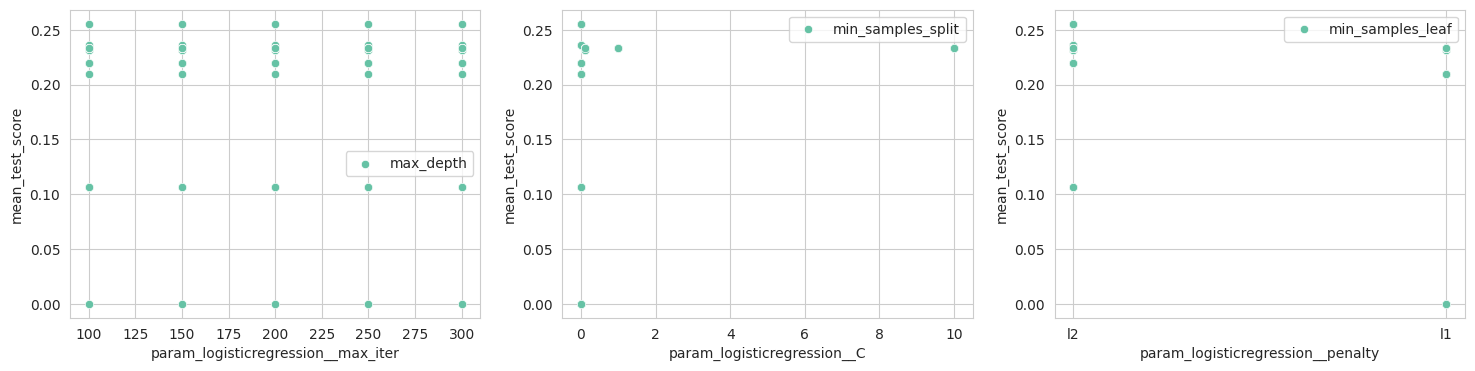

In [24]:
fig, eixo = plt.subplots(1, 3, figsize=(18, 4))
sns.scatterplot(x='param_logisticregression__max_iter', y='mean_test_score', data=df_reg_log_results, ax=eixo[0], label='max_depth')
sns.scatterplot(x='param_logisticregression__C', y='mean_test_score', data=df_reg_log_results, ax=eixo[1], label='min_samples_split')
sns.scatterplot(x='param_logisticregression__penalty', y='mean_test_score', data=df_reg_log_results, ax=eixo[2], label='min_samples_leaf')
plt.plot()

### 1.3 - GridSearch com `KNeighborsClassifier`

In [25]:
from sklearn.pipeline import Pipeline


max_iter =np.linspace(100, 300, 5, dtype=int)
c = [0.001, 0.01, 0.1, 1, 10]

parms_grid_knn = {
    'knn__n_neighbors': np.linspace(3, 15, 5, dtype=int),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
    }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

knn_grid_search = GridSearchCV(
                                        estimator=pipe_knn, 
                                        param_grid=parms_grid_knn, 
                                        cv=cv,
                                        scoring='recall',
                                        verbose=1,
                                        n_jobs=-1
)

knn_grid_search.fit(x_train, y_train)

print(knn_grid_search.best_params_)
df_knn_results =  pd.DataFrame(knn_grid_search.cv_results_)
df_knn_results.loc[[knn_grid_search.best_index_]]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.054967,0.00459,1.544743,0.179654,manhattan,3,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.386364,0.404545,0.393939,0.417549,0.362121,0.392904,0.018624,1


[]

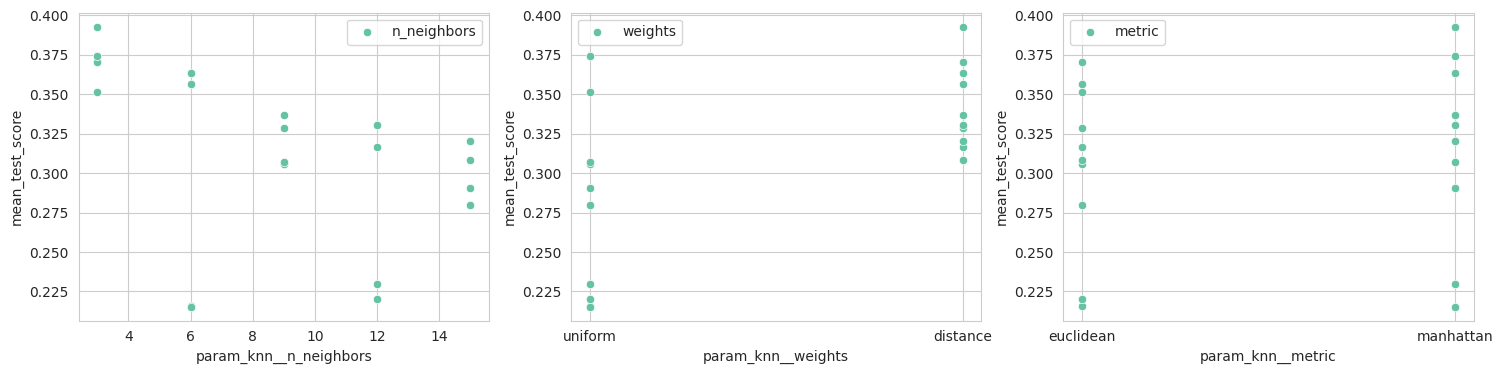

In [26]:
fig, eixo = plt.subplots(1, 3, figsize=(18, 4))
sns.scatterplot(x='param_knn__n_neighbors', y='mean_test_score', data=df_knn_results, ax=eixo[0], label='n_neighbors')
sns.scatterplot(x='param_knn__weights', y='mean_test_score', data=df_knn_results, ax=eixo[1], label='weights')
sns.scatterplot(x='param_knn__metric', y='mean_test_score', data=df_knn_results, ax=eixo[2], label='metric')
plt.plot()

## 2 - Método GridSearch com `Nested Cross Validation`

In [27]:
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

dt_nested_gs = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=parms_grid_dec_tree,
    cv=inner_cv,
    scoring='recall',
    verbose=1,
    n_jobs=-1
)

dt_nested_score = cross_val_score(dt_nested_gs, df_X, df_y, cv=outer_cv)
print(f'Nested CV Score: {round(dt_nested_score.mean() * 100, 2)}%')


Fitting 5 folds for each of 512 candidates, totalling 2560 fits


Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Nested CV Score: 24.28%


## 3.1 - Método RandomizedSearch com `DecisionTreeClassifier`

In [28]:
random_search_dec_tree = RandomizedSearchCV(
                                estimator=DecisionTreeClassifier(),
                                param_distributions=parms_grid_dec_tree,
                                n_iter=100,
                                scoring='recall',
                                n_jobs=-1,
                                cv=inner_cv,
)

rand_search_nested_cv_score = cross_val_score(random_search_dec_tree, df_X, df_y, cv=outer_cv)
print(f'Nested CV Score: {round(rand_search_nested_cv_score.mean() * 100, 2)}%')
random_search_dec_tree.fit(x_train, y_train)
random_search_dec_tree.best_params_

Nested CV Score: 26.76%


{'splitter': 'best',
 'min_samples_split': 10,
 'min_samples_leaf': 15,
 'max_features': 'log2',
 'max_depth': 12,
 'criterion': 'entropy'}

## 3.2 - Método RandomizedSearch com `DecisionTreeClassifier`

In [29]:
random_search_reg_log = RandomizedSearchCV(
                                estimator=make_pipeline(StandardScaler(), LogisticRegression()),
                                param_distributions=parms_grid_reg_log,
                                n_iter=50,
                                scoring='recall',
                                n_jobs=-1,
                                cv=inner_cv,
)

rand_search_nested_cv_score = cross_val_score(random_search_reg_log, df_X, df_y, cv=outer_cv)
print(f'Nested CV Score: {round(rand_search_nested_cv_score.mean() * 100, 2)}%')
random_search_reg_log.fit(x_train, y_train)
random_search_reg_log.best_params_

Nested CV Score: 25.23%


{'logisticregression__solver': 'liblinear',
 'logisticregression__penalty': 'l2',
 'logisticregression__max_iter': 300,
 'logisticregression__C': 0.001}

## Otimização Bayseana

- Define uma função objetivo
- Teorema de Bayes: P(A|B) = P(B|A) * P(A) / P(B) ou seja a probabilidade de A dado B é igual a probabilidade de B dado A vezes a probabilidade de A dividido pela probabilidade de B.

In [38]:
space = {
        'criterion': Categorical(['gini', 'entropy']),
        'max_depth': Integer(4, 12),
        'min_samples_split': Integer(5, 20),
        'min_samples_leaf': Integer(5, 20),
        'max_features': Categorical(['sqrt', 'log2']),
        'splitter': Categorical(['best', 'random'])
}

bayes_search_dec_tree = BayesSearchCV(
                                estimator=DecisionTreeClassifier(random_state=42),
                                search_spaces=space,
                                n_iter=50,
                                scoring='recall',
                                n_jobs=-11,
                                cv=inner_cv,
                                random_state=42
)
np.int = np.int_

bayes_score = cross_val_score(bayes_search_dec_tree, x_train, y_train, cv=outer_cv)

#print(f'Nested CV Score: {round(bayes_score.mean() * 100, 2)}%')


/home/dadaia/workspace/learning/3_AI/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/dadaia/workspace/learning/3_AI/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/dadaia/workspace/learning/3_AI/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/dadaia/workspace/learning/3_AI/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/dadaia/workspace/learning/3_AI/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:

In [ ]:
print(f'Nested CV Score: {round(bayes_score.mean() * 100, 2)}%')
bayes_search_dec_tree.fit(x_train, y_train)
bayes_search_dec_tree.best_params_
